In [394]:
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize
import PIL
import cv2

In [395]:
def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1))
    x_positions = np.arange(0,nx,step_x)
    x_labels = x[::step_x]
    return x_positions, x_labels

In [396]:
def imshow(img, lines=[]):
    fig = plt.figure(figsize=(12,16))
    ax = plt.axes()

    norm = Normalize(vmin=0, vmax=255, clip=True)

    im = ax.imshow(img,interpolation='none',aspect='auto',norm=norm)

    x_values = np.linspace(0, img.shape[1], num=100)
    for intercept, slope in lines:
        ls_y_values = intercept + slope * x_values
        ax.plot(x_values, np.clip(ls_y_values, 0, img.shape[0]), color="red", linewidth=2)

    plt.ylabel('time')
    plt.xlabel('space [m]')

    cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    plt.show()

In [397]:
# path_out = "./data-mm/"
path_out = "./Data/"
# path_out = "./Maria/"
files = glob.glob(path_out + "*")
files.sort()

In [398]:
dx = 5.106500953873407
dt = 0.0016


data = []
first_filename = files[0]
for file in files:
    data.append(np.load(file))
data = np.concatenate(data)
time_start = datetime.datetime.strptime(
    "2024-05-07 " + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S"
)
index = pd.date_range(start=time_start, periods=len(data), freq=f"{dt}s")


columns = np.arange(len(data[0])) * dx


df = pd.DataFrame(data=data, index=index, columns=columns)

In [399]:
def plot_lines_on_dataframe(df, lines, title="Lines Detected"):
    """
    Plots the DataFrame as an image with the detected lines overlaid.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame to visualize.
    lines (list): List of lines detected by HoughLinesP.
    title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 8))
    
    # Normalize the DataFrame to [0, 255] for visualization
    img = df.values
    norm = Normalize(vmin=img.min(), vmax=img.max())
    
    plt.imshow(img, cmap='viridis', aspect='auto', norm=norm, interpolation='none')
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            plt.plot([x1, x2], [y1, y2], color='red', linewidth=2)
    
    plt.title(title)
    plt.axis("off")
    plt.colorbar(label='Intensity')
    plt.show()


In [400]:
def plot_dataframe_as_image(df, a=6, b=9):
    """
    Plots a DataFrame as an image with continuous coloring based on the range of values
    using normalization.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the image data with numeric values.
    """
    # Normalize the data to the range [0, 1]
    norm = Normalize(vmin=df.min().min(), vmax=df.max().max())
    
    # Create the plot
    plt.figure(figsize=(a, b))
    plt.imshow(df, cmap='viridis', aspect='auto', norm=norm,  interpolation="none")
    # plt.colorbar(label='Value')
    plt.title('DataFrame Visualization')
    plt.axis('off')  # Turn off axis labels for better image representation
    
    # Display the plot
    plt.show()

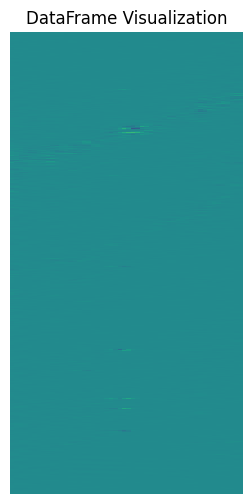

In [401]:
plot_dataframe_as_image(df.values, 3,6)

In [402]:
df = pd.DataFrame(data=data, index=index, columns=columns)
df.shape

(75000, 52)

In [403]:
# #downsampling -> decreasing the spatial resolution while keeping the 2D representation of an image
# #we downsample the rows
# #upsampling -> increasing the spatial resolution while keeping the 2D representation of an image
# #we upsample the columns
# df = pd.DataFrame(data=data, index=index, columns=columns)
# print(f"Shape of the df before downsampling: {df.shape}")

# df = df.reindex(columns=np.arange(df.columns[0], df.columns[-1] + dx, dx / 2)).interpolate(axis=1)
# print(f"Shape of the df after upsampling: {df.shape}")
# df = df[::2]

# print(f"Shape of the df after downsampling: {df.shape}")



# df = cv2.resize(df.values, (50, 1000), interpolation=cv2.INTER_AREA)
# print(f"Shape of the resized df: {df.shape}")


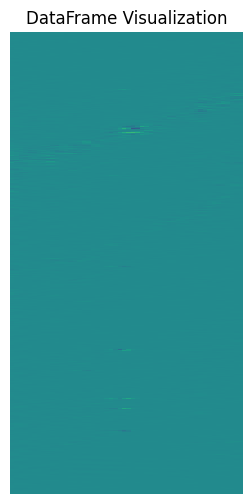

In [404]:
plot_dataframe_as_image(df,3,6)

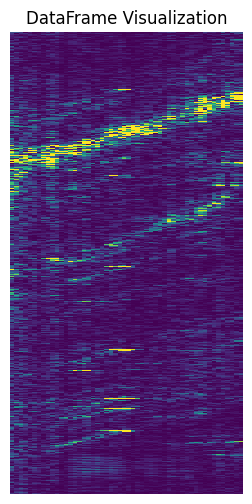

In [405]:
# # df = pd.DataFrame(data=data, index=index, columns=columns)
df = pd.DataFrame(df)
# # df = df.iloc[:, 2:]

# #ARITHMETIC OPERATIONS
# # df = df.iloc[::2, :]  #cet every second row, its gonna be better for filters
# df -= df.mean()
df = np.abs(df)

# #CLIP PERCENTILES FOR OUTLIERS
low, high = np.percentile(df, [3,99])
# # df[:] = df.apply(lambda col: np.where(((col < low)), low, col))
# # df[:] = df.apply(lambda col: np.where(((col > high)), high, col))
df.clip(low, high, inplace=True)
# print("percentile")
plot_dataframe_as_image(df.values, 3,6)
# print(df)

In [406]:
# #NORMALIZE values to 0,255
# normalized_image = cv2.normalize(df.values, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# df_normalized = pd.DataFrame(normalized_image)
# print("normalized")
# plot_dataframe_as_image(df_normalized,3, 6)

# # #COLUMN-WISE DENOISING BASED ON MEANS IN COLUMNS AND PERCENTILES
# # overall_mean = df_normalized.mean().mean()
# # perc = np.percentile(df_normalized.mean(axis=1), 90)
# # columns_above = df_normalized.columns[(df_normalized.mean() < perc)]
# # df_normalized[columns_above] -= overall_mean*2
# # print("columnwise normalization with mean-NEW")
# # plot_dataframe_as_image(df_normalized.values,3, 6)

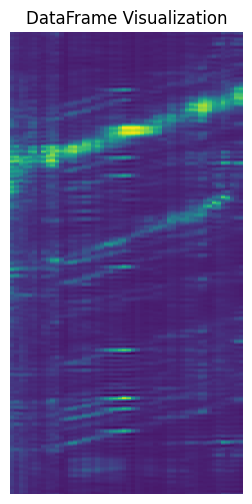

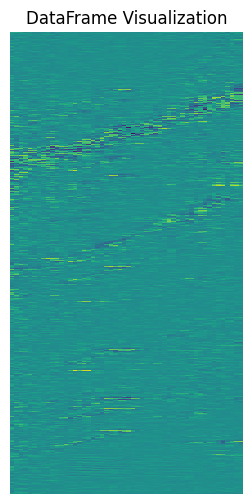

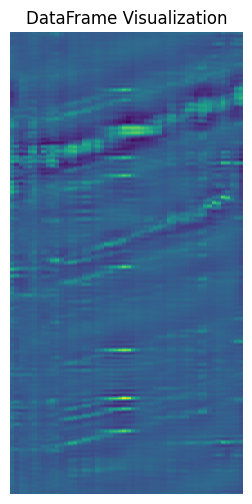

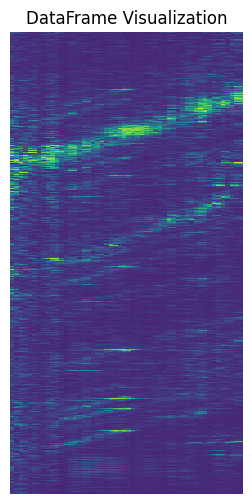

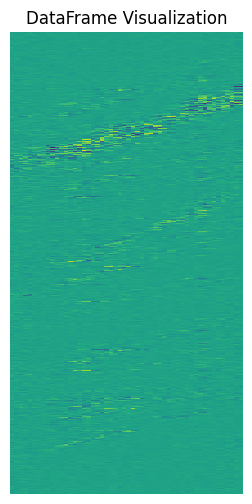

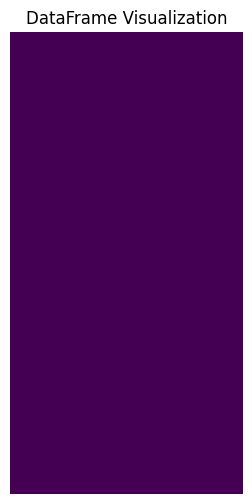

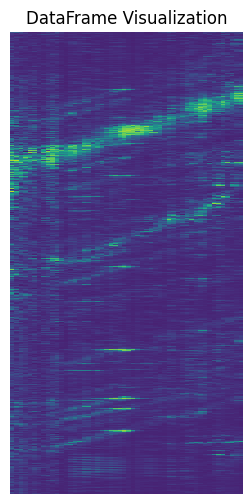

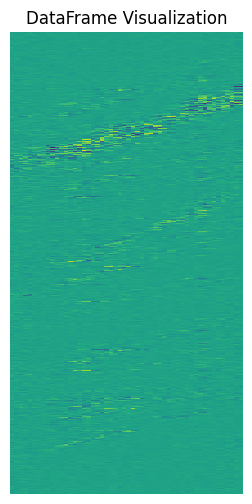

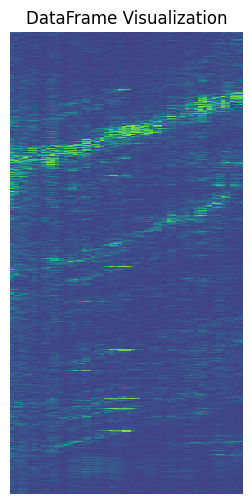

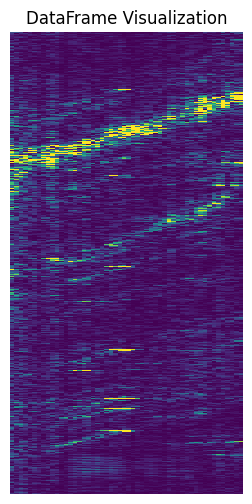

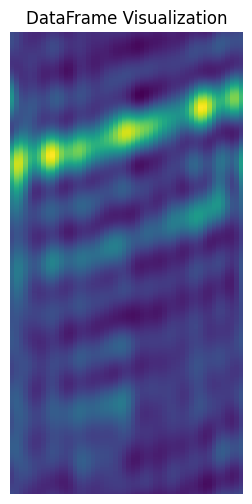

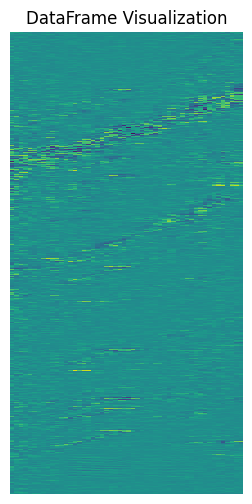

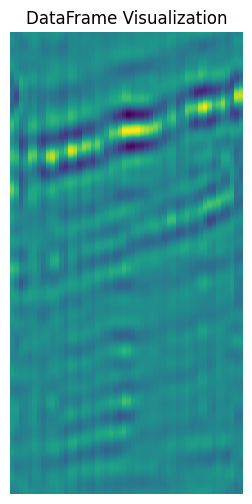

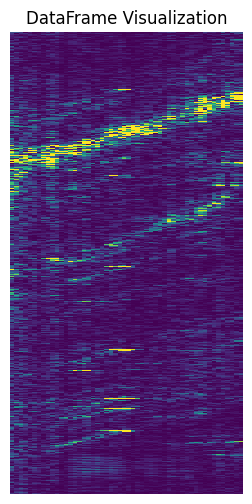

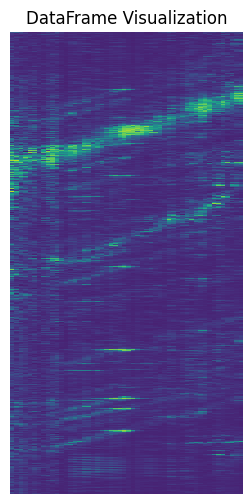

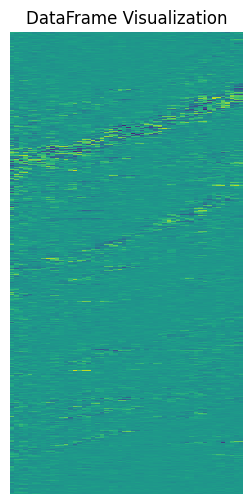

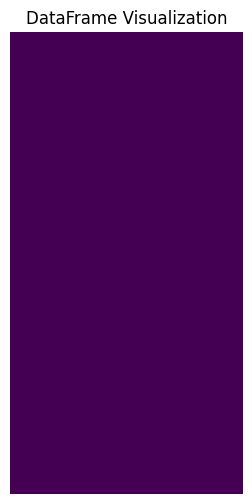

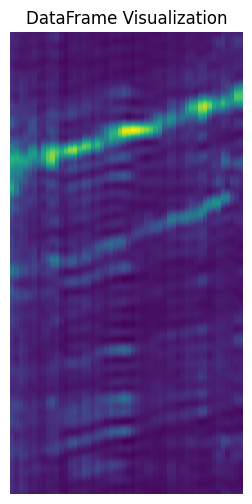

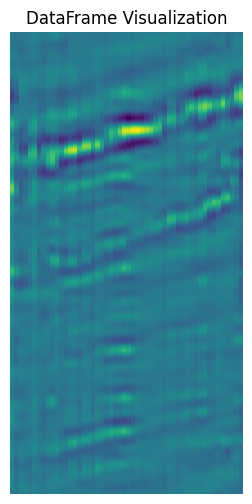

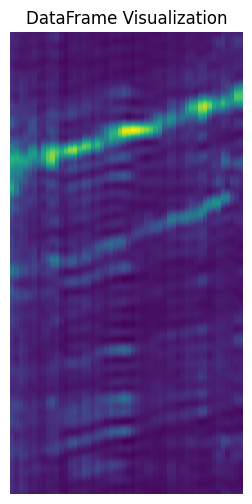

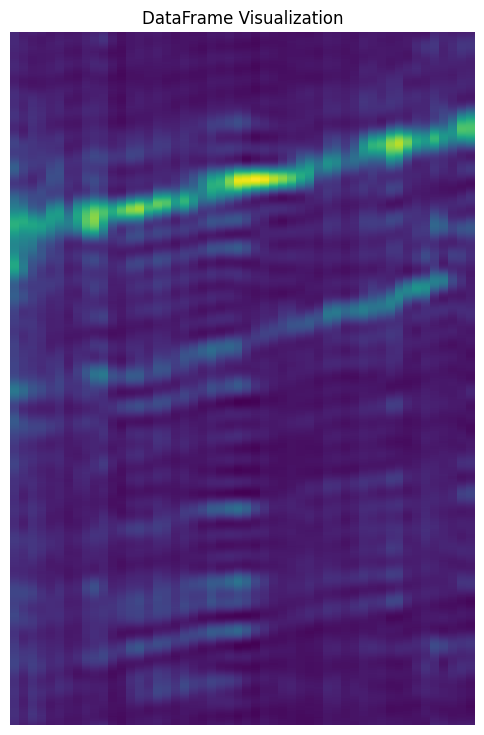

In [407]:
def get_mask(s, div):
    mask = np.zeros(s, np.float32)
    return cv2.circle(mask, (s[0] // 2, s[1] // 2), s[0] // div, 1, -1)


def fft(img, size=None):
    f = np.fft.fft2(img, size)
    fshift = np.fft.fftshift(f)
    spectrum = 20 * np.log(np.abs(fshift))
    return fshift, spectrum


def ifft(fshift):
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    return np.real(img_back)


def showFreqAndImages(frequencies, images):
    fig, axes = plt.subplots(2, len(frequencies), figsize=(20, 10))
    for i, (freq, img) in enumerate(zip(frequencies, images)):
        axes[0, i].imshow(freq, cmap="gray", vmin=0, vmax=255)
        axes[1, i].imshow(img, cmap="gray", vmin=0, vmax=255)
    plt.show()
    
# def get_mask(s, div):
#     mask = np.zeros(s, np.float32)
#     return cv2.circle(mask, (s[0] // 2, s[1] // 2), s[0] // div, 1, -1)
def get_mask(shape, div):
    mask = np.zeros(shape, np.float32)
    center_row, center_col = shape[0] // 2, shape[1] // 2

    rows_scale = shape[0] / max(shape)
    cols_scale = shape[1] / max(shape)
    axes = (int(center_col / div / cols_scale), int(center_row / div / rows_scale))

    mask = cv2.ellipse(mask, (center_col, center_row), axes, 0, 0, 360, 1, -1)
    return mask

def create_frequency_mask(shape, freq_min, freq_max):
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    Y, X = np.ogrid[:rows, :cols]
    dist_from_center = np.sqrt((X - center_col)**2 + (Y - center_row)**2)

    mask = np.logical_and(freq_min <= dist_from_center, dist_from_center <= freq_max)
    return mask.astype(np.float32)

img = df.values
fshift, spectrum = fft(img)


# Using create_frequency_mask
low_pass_mask = create_frequency_mask(img.shape, 0, 100)
high_pass_mask = 1 - create_frequency_mask(img.shape, 0, 100)

# This one may be also interesting if played with parameters
both_pass_mask = create_frequency_mask(img.shape, 10, 100)

low_pass_fshift = fshift * low_pass_mask
high_pass_fshift = fshift * high_pass_mask
both_pass_fshift = fshift * both_pass_mask


low_pass_img = ifft(low_pass_fshift)
high_pass_img = ifft(high_pass_fshift)
both_pass_img = ifft(both_pass_fshift)

plot_dataframe_as_image(low_pass_img,3,6)
plot_dataframe_as_image(high_pass_img,3,6)
plot_dataframe_as_image(both_pass_img,3,6)
# plot_dataframe_as_image(np.concatenate([low_pass_img, high_pass_img, both_pass_img], 1))


low_pass_mask = get_mask(img.shape, 5)
high_pass_mask = 1 - get_mask(img.shape, 5)

low_pass_fshift = low_pass_mask * fshift
high_pass_fshift = high_pass_mask * fshift
both_pass_fshift = high_pass_mask * fshift * low_pass_mask


low_pass_fshift_img = ifft(low_pass_fshift)
high_pass_fshift_img = ifft(high_pass_fshift)
both_pass_fshift_img = ifft(both_pass_fshift)

plot_dataframe_as_image(low_pass_fshift_img,3,6)
plot_dataframe_as_image(high_pass_fshift_img,3,6)
plot_dataframe_as_image(both_pass_fshift_img,3,6)
# plot_dataframe_as_image(np.concatenate([low_pass_fshift_img, high_pass_fshift_img, both_pass_fshift_img], 1))



low_pass_mask = get_mask(img.shape, 10)
high_pass_mask = 1 - get_mask(img.shape, 5)

low_pass_fshift = low_pass_mask * fshift
high_pass_fshift = high_pass_mask * fshift
both_pass_fshift = (low_pass_fshift + high_pass_fshift)


low_pass_fshift_img = ifft(low_pass_fshift)
high_pass_fshift_img = ifft(high_pass_fshift)
both_pass_fshift_img = ifft(both_pass_fshift)


plot_dataframe_as_image(low_pass_fshift_img,3,6)
plot_dataframe_as_image(high_pass_fshift_img,3,6)
plot_dataframe_as_image(both_pass_fshift_img,3,6)
# plot_dataframe_as_image(np.concatenate([low_pass_fshift_img, high_pass_fshift_img, both_pass_fshift_img], 1))



img_copy = img

fshift, spectrum = fft(img_copy)
og_img = ifft(fshift)

# Using create_frequency_mask
low_pass_mask = create_frequency_mask(img_copy.shape, 1, 10)
high_pass_mask = 1 - create_frequency_mask(img_copy.shape, 0, 120)

# This one may be also interesting if played with parameters
both_pass_mask = create_frequency_mask(img_copy.shape, 10, 20)

low_pass_fshift = fshift * low_pass_mask
high_pass_fshift = fshift * high_pass_mask
both_pass_fshift = fshift * both_pass_mask


low_pass_img = ifft(low_pass_fshift)
high_pass_img = ifft(high_pass_fshift)
both_pass_img = ifft(both_pass_fshift)


plot_dataframe_as_image(og_img,3,6)
plot_dataframe_as_image(low_pass_img,3,6)
plot_dataframe_as_image(high_pass_img,3,6)
plot_dataframe_as_image(both_pass_img,3,6)
# plot_dataframe_as_image(np.concatenate([og_img, low_pass_img, high_pass_img, both_pass_img], 1))


# Using get_mask
low_pass_mask = get_mask(img_copy.shape, 10)
high_pass_mask = 1 - get_mask(img_copy.shape, 50)

low_pass_fshift = low_pass_mask * fshift
high_pass_fshift = high_pass_mask * fshift
both_pass_fshift = high_pass_mask * fshift * low_pass_mask

low_pass_fshift_img = ifft(low_pass_fshift)
high_pass_fshift_img = ifft(high_pass_fshift)
both_pass_fshift_img = ifft(both_pass_fshift)

both_pass_fshift_img[both_pass_fshift_img < 10] = 0

plot_dataframe_as_image(og_img,3,6)
plot_dataframe_as_image(low_pass_fshift_img,3,6)
plot_dataframe_as_image(high_pass_fshift_img,3,6)
plot_dataframe_as_image(both_pass_fshift_img,3,6)
# plot_dataframe_as_image((np.concatenate([og_img, low_pass_fshift_img, high_pass_fshift_img, both_pass_fshift_img], 1)))



fshift, spectrum = fft(img)

mod_fshift = fshift.copy()

mask_1 = create_frequency_mask(img.shape, 1, 30)
mask_2 = create_frequency_mask(img.shape, 10, 30)

mask_1_fshift = mask_1 * mod_fshift
mask_2_fshift = mask_2 * mod_fshift
both_pass_fshift = (mask_1_fshift)


mask_1_fshift_img = ifft(mask_1_fshift)
mask_2_fshift_img = ifft(mask_2_fshift)
both_pass_fshift_img = ifft(both_pass_fshift)

# display(PIL.Image.fromarray((spectrum * mask_1).clip(0, 255).astype("uint8")))


plot_dataframe_as_image(mask_1_fshift_img,3,6)
plot_dataframe_as_image(mask_2_fshift_img,3,6)
plot_dataframe_as_image(both_pass_fshift_img,3,6)
# plot_dataframe_as_image(np.concatenate([mask_1_fshift_img, mask_2_fshift_img, both_pass_fshift_img], 1))

plot_dataframe_as_image(both_pass_fshift_img)

# m2 = get_mask(normalized_image.shape, 2)
# fshift, spectrum = fft(normalized_image)
# img_back_2 = ifft(fshift * m2)
# plot_dataframe_as_image(np.concatenate([normalized_image, spectrum * m2, img_back_2], 1))


# f = np.fft.fft2(normalized_image)
# fshift = np.fft.fftshift(f)
# magnitude_spectrum = 20 * np.log(np.abs(fshift))
# f_ishift = np.fft.ifftshift(fshift) #inverse shift
# img_back = np.fft.ifft2(f_ishift)  #inverse fourier transform
# img_back = np.real(img_back) #getting real part of the image
# plot_dataframe_as_image(np.concatenate([normalized_image, magnitude_spectrum, img_back], 1))


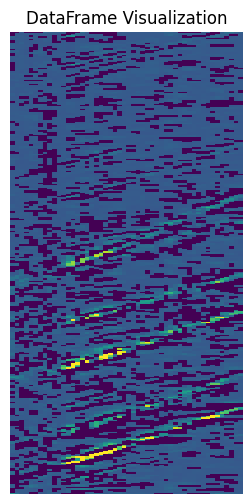

In [408]:
def column_wise_median_filter(df, kernel_size=5):
    """
    Applies a median filter to each column in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        kernel_size (int): Size of the median filter window (must be odd).
    
    Returns:
        pd.DataFrame: Denoised DataFrame.
    """
    filtered_data = df.copy()
    
    for col in df.columns:
        filtered_data[col] = cv2.medianBlur(df[col].values.astype(np.uint8), kernel_size)
    
    return filtered_data

# Apply the median filter
df_denoised = column_wise_median_filter(df_normalized, kernel_size=5)

# Visualize the result
plot_dataframe_as_image(df_denoised.values, 3, 6)

In [409]:
# # EQUALIZE
# clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
# equalized_image = clahe.apply(normalized_image)
# df_equalized = pd.DataFrame(equalized_image, columns = df.columns)
# print("equalized_image")
# plot_dataframe_as_image(df_equalized,3,6)

threshold below 20


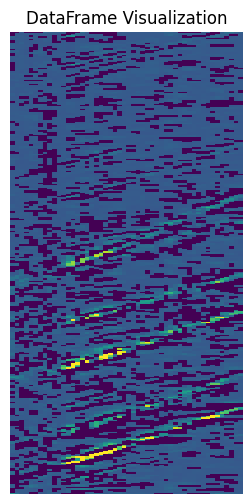

In [410]:
#BAD- INDUCES NOISE
# df_normalized = df_normalized.apply(lambda x: x - x.mean())
# print("columnwise normalization")
# plot_dataframe_as_image(df_normalized,3, 6)
df_normalized[:] = df_denoised.apply(lambda col: np.where(((col < 70)), 0, col))
print("threshold below 20")
plot_dataframe_as_image(df_normalized.values,3, 6)

Result of denoising


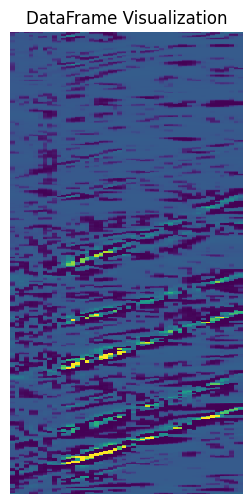

In [411]:
#NLM DENOISING
image = df_normalized.values.astype(np.uint8)
denoised_image2 = cv2.fastNlMeansDenoising(
    image,                      
    h=20,                       
    templateWindowSize=7,       
    searchWindowSize=21         
)
# df = pd.DataFrame(denoised_image, columns=df_normalized.columns)
print("Result of denoising")
# plot_dataframe_as_image(df, 3,6)
df2  = pd.DataFrame(denoised_image2, columns=df_normalized.columns)
plot_dataframe_as_image(df2.values, 3,6)

In [412]:
# #GAUSSIAN ON 3,21 KERNEL
# kernel = (3,21)
# df_gauss = pd.DataFrame(cv2.GaussianBlur(df.values.astype(np.float32), kernel, 3), columns = df.columns)
# print("Gauss")
# plot_dataframe_as_image(df_gauss,3,6)

kernel = (3,3)
df_gauss = pd.DataFrame(cv2.GaussianBlur(df2.values.astype(np.float32), kernel, 5), columns = df.columns)
print("Gauss on 2nd denoise")
plot_dataframe_as_image(df_gauss.values,3,6)

ValueError: Shape of passed values is (1000, 50), indices imply (1000, 52)

normalized background


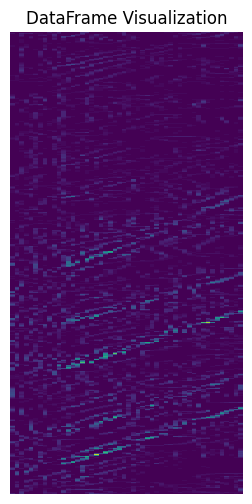

In [ ]:
#THIS IS NICE. IT REMOVES GAUSSIAN-BACKGROUND BLUR, AND THEN IT APPLIES MORE CONTRAST
background = cv2.GaussianBlur(df_gauss.values.astype(np.uint8), (3,3), 0)
normalized_image = cv2.subtract(df_gauss.values.astype(np.uint8), background)
normalized_image = cv2.normalize(normalized_image, None, 0, 255, cv2.NORM_MINMAX)
print("normalized background")
df_norm = pd.DataFrame(normalized_image, columns = df.columns)
plot_dataframe_as_image(df_norm.values,3,6)

binarized after gauss


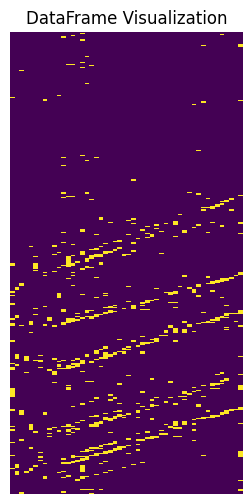

In [ ]:
#BINARIZATION
df_binarized = (df_norm > np.percentile(df_norm, 95)).astype(int)
print("binarized after gauss")
plot_dataframe_as_image(df_binarized.values,3,6)

In [ ]:
# # Perform morphological closing to fill holes in the binary image
# kernel = np.ones((3, 3), np.uint8)  # Define a kernel for the morphological operation
# closed_image = cv2.morphologyEx(df_binarized.values.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=1)

# print("Connected lines after closing")
# plot_dataframe_as_image(closed_image, 3, 6)

In [ ]:
# #OPENING FOR NOISE REDUCTION
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
# opening = cv2.morphologyEx(closed_image.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=1)
# print("opening")
# plot_dataframe_as_image(pd.DataFrame(opening), 3, 6)

In [413]:
# edges = cv2.Canny(df2.values.astype(np.uint8), 50, 100)
img_filtered = both_pass_fshift_img.clip(0, 255).astype(np.uint8)
edges = cv2.Canny(img_filtered, 50, 100)

if edges is not None and np.any(edges):
    edges_df = pd.DataFrame(edges)
    plot_dataframe_as_image(edges_df, 3, 6)
else:
    print("No edges were detected.")

No edges were detected.


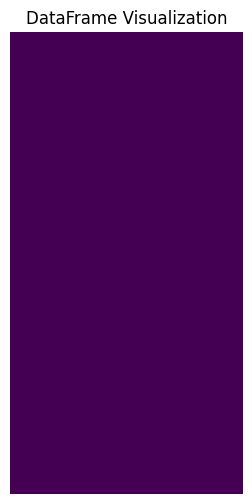

In [414]:
edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
plot_dataframe_as_image(edges_closed, 3, 6)

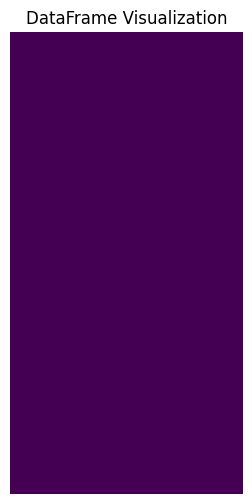

In [415]:
edges_dilated = cv2.dilate(edges_closed, kernel, iterations=1)
plot_dataframe_as_image(edges_dilated, 3, 6)

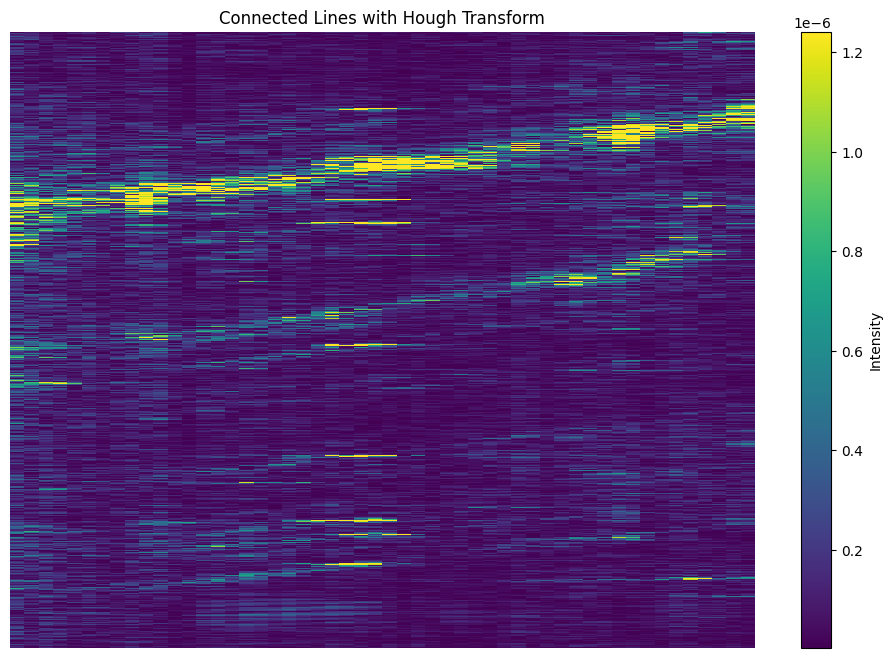

In [416]:
lines = cv2.HoughLinesP(edges_dilated, rho=1, theta=np.pi / 180, threshold=10, minLineLength=50, maxLineGap=10)
plot_lines_on_dataframe(df, lines, title="Connected Lines with Hough Transform")

In [417]:
def merge_lines(lines, min_distance=20, max_angle_diff=5):
    """
    Merges lines that are close together and have similar angles.

    Parameters:
    lines (list): List of lines detected by HoughLinesP (x1, y1, x2, y2).
    min_distance (float): Minimum distance to consider two lines as part of the same group.
    max_angle_diff (float): Maximum angle difference (in degrees) to group lines.

    Returns:
    list: A list of merged lines.
    """
    if lines is None or len(lines) == 0:
        return []

    merged_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        added = False

        for merged in merged_lines:
            mx1, my1, mx2, my2, mangle = merged
            # Calculate the midpoints of the two lines for better comparison
            mid_x1, mid_y1 = (mx1 + mx2) / 2, (my1 + my2) / 2
            mid_x2, mid_y2 = (x1 + x2) / 2, (y1 + y2) / 2
            mdistance = np.sqrt((mid_x1 - mid_x2) ** 2 + (mid_y1 - mid_y2) ** 2)

            if mdistance < min_distance and abs(mangle - angle) < max_angle_diff:
                # Merge lines by recalculating the start and end points
                merged[0] = min(mx1, x1)
                merged[1] = min(my1, y1)
                merged[2] = max(mx2, x2)
                merged[3] = max(my2, y2)
                merged[4] = (mangle + angle) / 2
                added = True
                break

        if not added:
            merged_lines.append([x1, y1, x2, y2, angle])

    # Return the merged lines in the format [[[x1, y1, x2, y2]], ...]
    return [[[line[0], line[1], line[2], line[3]]] for line in merged_lines]


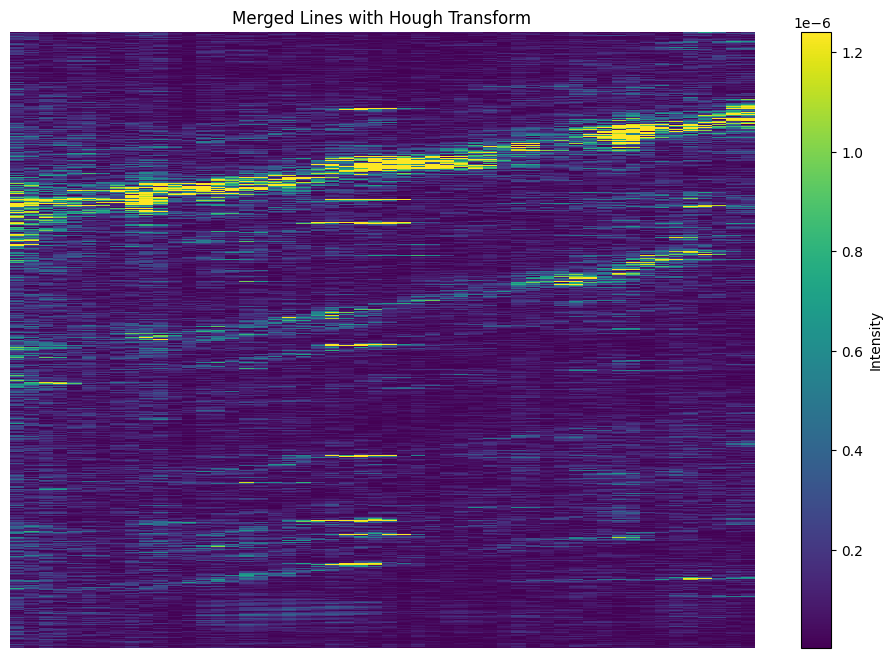

In [418]:
merged_lines = merge_lines(lines)

# Plot merged lines
plot_lines_on_dataframe(df, merged_lines, title="Merged Lines with Hough Transform")

In [419]:
df.shape

(75000, 52)

In [420]:
#FAJNY KOD DO USTAWIENIA DX I DT

# Original values
original_dx = 5.106500953873407
original_dt = 0.0016
original_shape = (75000, 52)  # (rows, columns)

# New dataframe shape
new_shape = (1000, 48)  # (rows, columns)

# Calculate new dx and dt
new_dt = original_dt * (original_shape[0] / new_shape[0])
new_dx = original_dx * (original_shape[1] / new_shape[1])

print(f"New dx: {new_dx:.3f} meters/column")
print(f"New dt: {new_dt:.3f} seconds/row")


New dx: 5.532 meters/column
New dt: 0.120 seconds/row


In [421]:
def calculate_velocities(lines, dx, dt):
    """
    Calculate velocities for each line based on its slope.

    Parameters:
        lines (list): List of merged lines in the format [[[x1, y1, x2, y2]], ...].
        dx (float): Spatial resolution (distance per column).
        dt (float): Temporal resolution (time per row).

    Returns:
        list: A list of velocities corresponding to each line.
    """
    velocities = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 != x1:  # Avoid division by zero
            slope = (y2 - y1) / (x2 - x1)  # Slope in pixels
            velocity = abs(dx / (slope * dt)) * 3.6  # Convert to km/h
            velocities.append(velocity)
        else:
            velocities.append(None)  # Vertical line: undefined velocity
    return velocities

velocities = calculate_velocities(merged_lines, new_dx, new_dt)
print(velocities)




[]


In [422]:
def plot_lines_with_velocities(df, lines, velocities, title="Lines with Velocities"):
    """
    Plots lines on the DataFrame with velocity annotations.

    Parameters:
        df (pd.DataFrame): The DataFrame to visualize.
        lines (list): List of lines in the format [[[x1, y1, x2, y2]], ...].
        velocities (list): List of velocities corresponding to each line.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 8))
    plt.imshow(df.values, cmap="viridis", aspect="auto", interpolation="none")
    plt.colorbar(label="Intensity")
    
    if lines is not None:
        for i, line in enumerate(lines):
            x1, y1, x2, y2 = line[0]
            plt.plot([x1, x2], [y1, y2], color='red', linewidth=2)

            # Annotate velocity
            if velocities[i] is not None:
                mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
                plt.text(mid_x, mid_y, f"{velocities[i]:.2f} km/h", color="yellow", fontsize=10, ha="center", va="center")

    plt.title(title)
    plt.xlabel("Columns (Space)")
    plt.ylabel("Rows (Time)")
    plt.show()


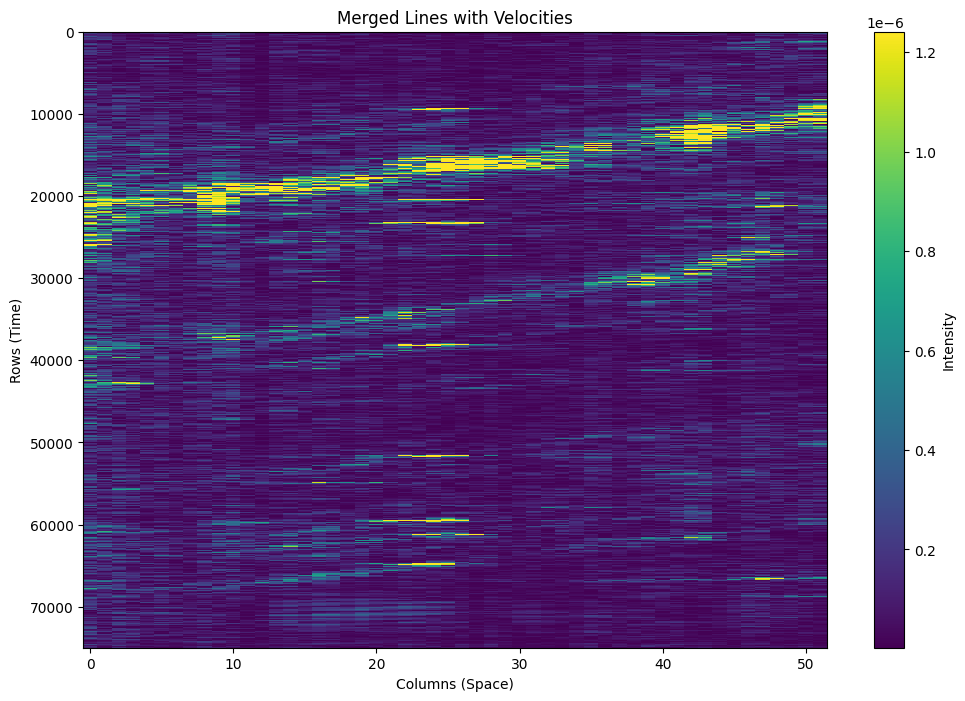

In [423]:
plot_lines_with_velocities(df, merged_lines, velocities, title="Merged Lines with Velocities")

In [424]:
#EROSION, 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
eroded_image = cv2.erode(df_binarized.values.astype(np.uint8), kernel, iterations=1)
df_eroded = pd.DataFrame(eroded_image, columns=df.columns)
print("erosion")
plot_dataframe_as_image(df_eroded,3,6)

ValueError: Shape of passed values is (1000, 50), indices imply (1000, 52)

dilation


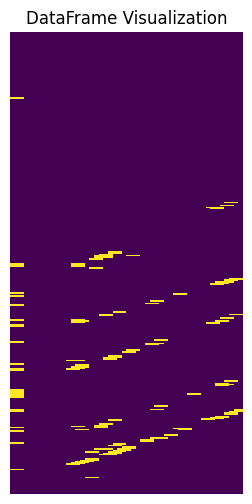

In [ ]:
#DILATION
kernel_diagonal = np.ones((2,2), dtype=np.uint8)
# for i in range(20):
#     kernel_diagonal[i, min(i, 4)] = 1
kernel_flip =  np.flip(kernel_diagonal,axis=1 )
# print(kernel_flip)
img_bin_dil = cv2.dilate(df_eroded.values.astype(np.uint8), kernel_flip, iterations=2)   #i have like 20 pixels gaps on vertical. 
df_dilated = pd.DataFrame(img_bin_dil, columns=df.columns)
print("dilation")
plot_dataframe_as_image(df_dilated,3,6)

smooth edges


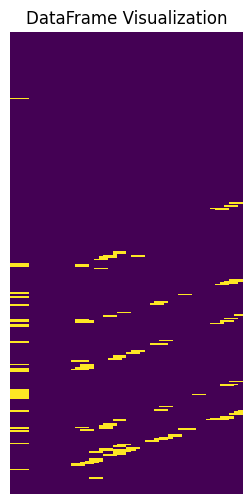

In [ ]:
# CLOSE VERTICAL
vertical_kernel = np.ones((2, 2), dtype=np.uint8)
closed_image = cv2.morphologyEx(df_dilated.values.astype(np.uint8), cv2.MORPH_CLOSE, vertical_kernel)
print("smooth edges")
df_smooth = pd.DataFrame(closed_image, columns = df.columns)
plot_dataframe_as_image(df_smooth,3,6)